In [1]:
import sys; sys.path.insert(0, '..')
import os
import time
import pandas as pd
import keras
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
from dataclasses import dataclass
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from keras.losses import CategoricalCrossentropy
from keras import activations
from sklearn.metrics import confusion_matrix
from utils.df_utils import df_wrapper
from utils.declarations import training_files, testing_files, POSE_MAP

In [2]:
AMOUNT_OF_SENSORS = 1
VALIDATION_TESTSET = "004"

In [3]:
x_train_arr = []
for key in training_files:
    elem = df_wrapper(training_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(training_files[key].annot_file, POSE_MAP)
    x_train_arr.append(elem)
    
x_train = pd.concat([x.df.drop([' TimeStamp (s)', 'Pose'],axis=1) for x in x_train_arr])
y_train = pd.concat([x.df['Pose'] for x in x_train_arr])

In [4]:
x_test_dict = dict()
y_test_dict = dict()
for key in testing_files:
    elem = df_wrapper(testing_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(testing_files[key].annot_file, POSE_MAP)
    y_test = elem.df["Pose"]
    y_test.index = [i for i in range(len(y_test))]
    x_test_dict[key] = elem.df
    y_test_dict[key] = y_test
    print(key)

x_test = x_test_dict[VALIDATION_TESTSET].drop([' TimeStamp (s)', 'Pose'], axis=1) 
y_test = y_test_dict[VALIDATION_TESTSET]

001
002
003
004
005
006
007
008
009
010


In [19]:
# Create numpy arrays
x_train_numpy = x_train.values
x_test_numpy = x_test.values
y_train_numpy = y_train.values
y_test_numpy = y_test.values

# Hot encode categories into numbers
y_train = to_categorical(y_train_numpy,9)
y_test = to_categorical(y_test_numpy,9)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [20]:
print("TRAINING SHAPES")
print("x_train_numpy: ", x_train_numpy.shape)
print("y_train_numpy: ", y_train_numpy.shape)

print("TESTING SHAPES")
print("x_test_numpy: ", x_test_numpy.shape)
print("y_test_numpy: ", y_test_numpy.shape)

TRAINING SHAPES
x_train_numpy:  (468584, 13)
y_train_numpy:  (468584,)
TESTING SHAPES
x_test_numpy:  (8367, 13)
y_test_numpy:  (8367,)


In [43]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(x_train_numpy)
scaler.fit(x_test_numpy)

RobustScaler()

In [44]:

OPTIM = Adam(learning_rate=0.00001)
# OPTIM = RMSprop(learning_rate=LR)


In [45]:

callbacks = [
    keras.callbacks.CSVLogger("ANN_1_sensor_3.csv", separator=",", append=False),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
]

In [46]:
model = Sequential()
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(rate=0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(12, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(9, activation='softmax'))

model.compile(optimizer=OPTIM, loss=CategoricalCrossentropy(), metrics=['accuracy'])


In [47]:
model.fit(x=x_train_numpy, y=y_train, batch_size=8192, epochs=2000, validation_data=(x_test_numpy, y_test), callbacks=callbacks)

och 1044/2000
58/58 [==============================] - 2s 31ms/step - loss: 0.6446 - accuracy: 0.7697 - val_loss: 0.6270 - val_accuracy: 0.7741
Epoch 1045/2000
58/58 [==============================] - 2s 31ms/step - loss: 0.6472 - accuracy: 0.7697 - val_loss: 0.6265 - val_accuracy: 0.7751
Epoch 1046/2000
58/58 [==============================] - 2s 30ms/step - loss: 0.6454 - accuracy: 0.7707 - val_loss: 0.6261 - val_accuracy: 0.7763
Epoch 1047/2000
58/58 [==============================] - 2s 31ms/step - loss: 0.6445 - accuracy: 0.7708 - val_loss: 0.6263 - val_accuracy: 0.7727
Epoch 1048/2000
58/58 [==============================] - 2s 31ms/step - loss: 0.6447 - accuracy: 0.7700 - val_loss: 0.6257 - val_accuracy: 0.7742
Epoch 1049/2000
58/58 [==============================] - 2s 31ms/step - loss: 0.6470 - accuracy: 0.7693 - val_loss: 0.6249 - val_accuracy: 0.7757
Epoch 1050/2000
58/58 [==============================] - 2s 31ms/step - loss: 0.6444 - accuracy: 0.7717 - val_loss: 0.6245 - v

<AxesSubplot:>

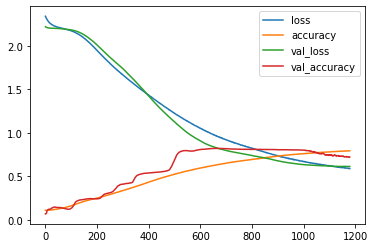

In [48]:
history = pd.DataFrame(model.history.history)
history.plot()

In [49]:
# df = pd.read_csv("ANN_1_sensor_1.csv")
# df["kjoring"] = 1
# df.to_csv("ANN_1_sensor_1.csv", index=False)

In [50]:
print("Classification accuracy:")
classification_dict = dict()
accuracy_list = list() 

for key in x_test_dict:
    x_test_numpy_temp = x_test_dict[key].drop([' TimeStamp (s)', 'Pose'], axis=1).values
    scaler.fit(x_test_numpy_temp)
    classify = model.predict(x_test_numpy_temp)
    classifications = [i.argmax() for i in classify]
    annotated_positions = y_test_dict[key].to_numpy()
    correct_classifications = (classifications == annotated_positions).sum()
    accuracy_list.append(round(correct_classifications/len(classifications)*100,2))
    print(f"{key}: {accuracy_list[-1]}%")
    classification_dict[key] = classifications

print(f"Average accuracy: {round(sum(accuracy_list)/len(accuracy_list),2)}%")

Classification accuracy:
001: 84.8%
002: 64.27%
003: 34.7%
004: 72.13%
005: 76.39%
006: 64.85%
007: 67.75%
008: 93.02%
009: 90.41%
010: 44.78%
Average accuracy: 69.31%


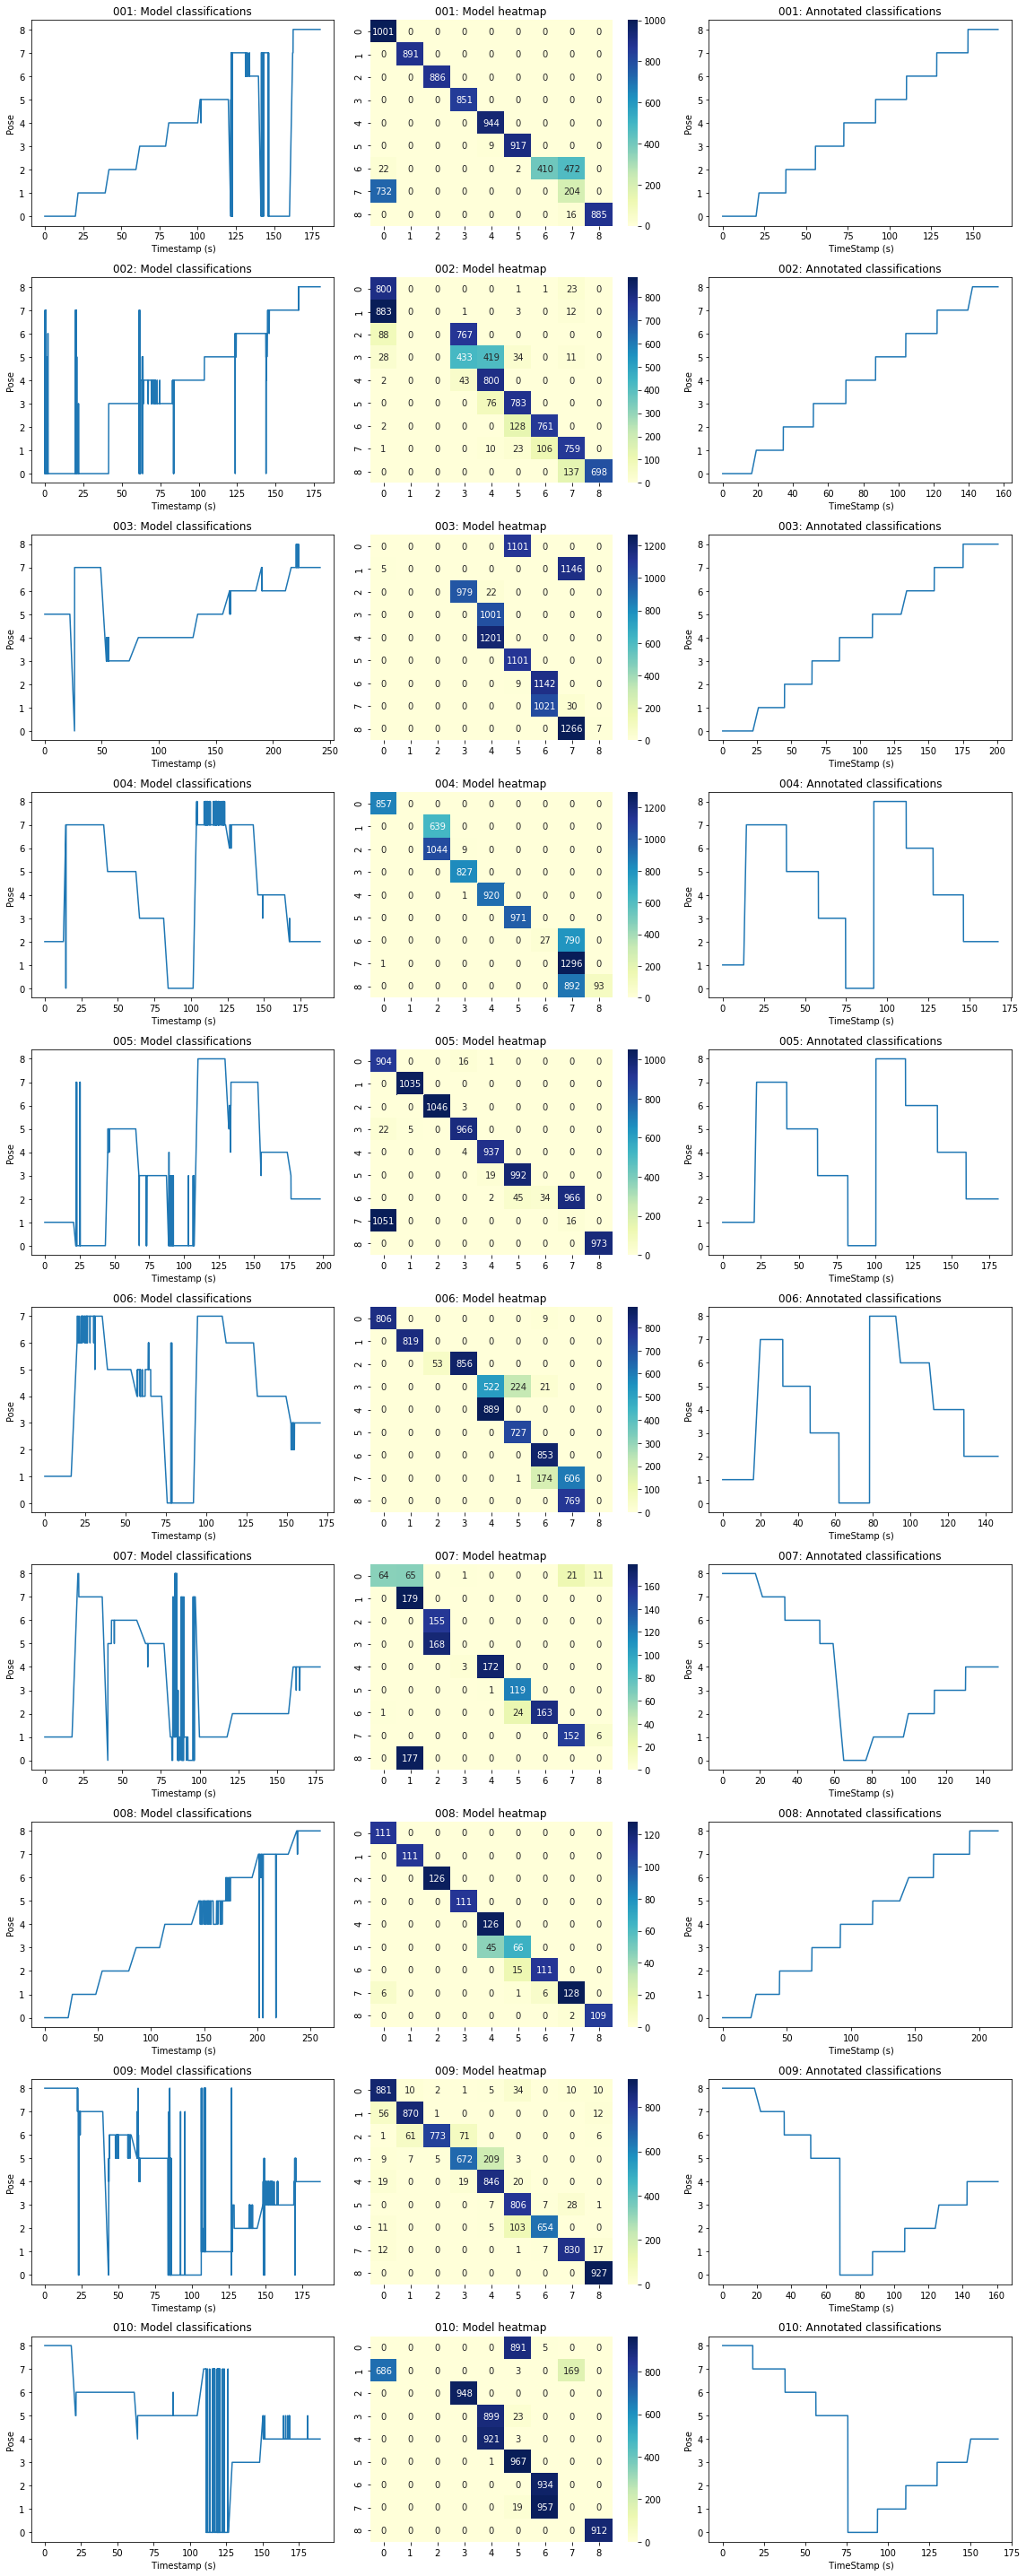

In [51]:
width=16
height=4*len(x_test_dict)
fig, axes = plt.subplots(len(x_test_dict), 3, figsize=(width, height))
for i, key in enumerate(x_test_dict):
    cols = [f"{key}: Model classifications", f"{key}: Model heatmap", f"{key}: Annotated classifications", f"{key}: Annotated heatmap"]
    df_predict = pd.DataFrame({' Timestamp (s)': x_test_dict[key][' TimeStamp (s)'],'Pose':classification_dict[key]})
    sns.lineplot(ax=axes[i, 0], data=df_predict,x=' Timestamp (s)',y='Pose')
    sns.heatmap(ax=axes[i, 1], data=confusion_matrix(y_test_dict[key], classification_dict[key]), cmap="YlGnBu", annot=True, fmt="d")
    sns.lineplot(ax=axes[i, 2], data=x_test_dict[key], x=" TimeStamp (s)", y='Pose')
    # sns.heatmap(ax=axes[i, 3], data=confusion_matrix(y_test_dict[key], y_test_dict[key].to_numpy()), cmap="YlGnBu", annot=True, fmt="d")
    for ax, col in zip(axes[i], cols): ax.set_title(col)
fig.tight_layout()

plt.show()


In [52]:
fig.savefig("ANN_1_sensor_3_heatmap_and_line.png")

In [53]:
model.save("ANN_1_sensor_3.h5")